In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import time
import random
from PIL import Image
import pickle
import joblib
import re

from sklearn import preprocessing
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate,Conv1D,MaxPooling2D,Activation
from keras.layers import BatchNormalization
from keras.layers import Embedding
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import keras_tuner
from tensorflow import keras
import tensorflow_hub as hub
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## 1. Modelling on MSCOCO Dataset

### 1.1 Read Data

In [ ]:
colab_path = "/content/drive/MyDrive/Applied AI/CS2/Data/"
preprocessed_data_df = pd.read_csv(colab_path+"mscoco_train2014_preprocessed.csv")
print("Number of Datapoints in MSCOCO Dataset:",len(preprocessed_data_df))
preprocessed_data_df.head(3)

Number of Datapoints in MSCOCO Dataset: 409050


image_id  question_id  \
0  train2014/COCO_train2014_000000458752.jpg    458752000   
1  train2014/COCO_train2014_000000458752.jpg    458752001   
2  train2014/COCO_train2014_000000458752.jpg    458752002   

                      question_preprocessed      question_type  \
0  what is this photo taken looking through       what is this   
1         what position is this man playing               what   
2           what color is the players shirt  what color is the   

  answer_preprocessed answer_max  \
0                 net        net   
1             pitcher    pitcher   
2              orange     orange   

                                             answers answer_type  
0       net,net,net,netting,net,net,mesh,net,net,net       other  
1  pitcher,catcher,pitcher,pitcher,pitcher,pitche...       other  
2  orange,orange,orange,orange,orange,orange,oran...       other

In [ ]:
print("Unique number of answers of MSCOCO Dataset:",len(set(preprocessed_data_df['answer_preprocessed'])))
print("Unique set of answers of MSCOCO Dataset:",set(preprocessed_data_df['answer_preprocessed']))

Unique number of answers of MSCOCO Dataset: 9647
Unique set of answers of MSCOCO Dataset: {'duvet', 'turkcell', 'qantas', 'choice', '77', 'hydrangeas', 'mumbai', 'cartons', 'sunkist', 'leather', 'towel', 'surveillance', 'strike', 'ranch', 'unloading', 'touching', 'roaster', 'helium', '.99', '5288', 'wii', 'pansies', 'cathedral', 'slazeng', '37', 'turf', 'car', 'display', 'camping', 'ornament', '4.50', 'reeds', 'hardcover', 'rc', 'bandage', 'skipton', 'dividers', 'inbound', 'chevy', 'dimly', '60', 'wharf', '.69', 'death', 'penzance', 'tractor', 'zimmerman', 'bridge', 'junkyard', 'braid', 'headphones', 'en09', 'enterprise', 'android', 'sleeve', '237a', 'creepy', 'atlantic', '1772', '.77', 'kipsta', 'barbed', '135', 'parakeets', 'national', 'poncho', 'sunning', 'lawyers', '80s', 'rz5792', 'sheet', 'storm', 'j', 'bride', 'joe', 'buddhist', '892', 'downstream', 'singles', 'graco', 'foul', 'sky', 'maple', 'co68', 'nestle', 'kemp', 'bunt', 'webpage', '1500', 'cirrus', 'rhubarb', 'scooters', '

In [ ]:
# create dataframe of unique answers and its counts in decending order of answer_count
answer_preprocessed = list(preprocessed_data_df['answer_preprocessed'])
count = {}
for i in answer_preprocessed:
    count[i] = count.get(i, 0) + 1
    
answer_df = pd.DataFrame(list(count.items()),columns=["answer","answer_count"])
answer_df["answer%"] = answer_df["answer_count"]/len(answer_preprocessed)*100  
answer_df = answer_df.sort_values(by='answer_count',ascending=False)
answer_df.head(5)

answer  answer_count    answer%
3     yes         84978  20.774477
9      no         82516  20.172595
12      1         12541   3.065884
17      2         12215   2.986188
4   white          8916   2.179685

In [ ]:
# Consider top 1000 answers as class label
top_1000_answers = list(answer_df['answer'])[:1000]

data_df = pd.DataFrame()
for i in (range(len(top_1000_answers))):
  data_df = pd.concat([data_df, preprocessed_data_df[preprocessed_data_df.answer_preprocessed == top_1000_answers[i]]])

print(f"Top 1000 answers coverd {round(len(data_df)/443757*100,2)}% of datapoints")

labelencoder = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/labelencoder.pkl', 'rb'))
# labelencoder = preprocessing.LabelEncoder()
# labelencoder.fit(top_1000_answers)
# pickle.dump((labelencoder),open('/content/drive/MyDrive/Applied AI/CS2/model/labelencoder.pkl','wb'))

data_df['class_label'] = labelencoder.transform(list(data_df['answer_preprocessed']))
print("Number of Class Labels:",len(labelencoder.classes_))

data_df = data_df.drop(['question_id', 'question_type','answer_max', 'answer_type'], axis=1)
print("Number of datapoints of final dataset:",len(data_df))
# data_df.to_csv("/content/drive/MyDrive/Applied AI/CS2/Data/mscoco_train2014_preprocessed_k1000.csv",index=False)
data_df.head(3)

Top 1000 answers coverd 85.76% of datapoints
Number of Class Labels: 1000
Number of datapoints of final dataset: 380554


image_id  \
3   train2014/COCO_train2014_000000458752.jpg   
8   train2014/COCO_train2014_000000524291.jpg   
10  train2014/COCO_train2014_000000393221.jpg   

                         question_preprocessed answer_preprocessed  \
3   is this man a professional baseball player                 yes   
8                           is the dog waiting                 yes   
10                             is the sky blue                 yes   

                                    answers  class_label  
3    yes,yes,yes,yes,yes,no,yes,yes,yes,yes          994  
8   yes,yes,yes,yes,yes,yes,yes,yes,yes,yes          994  
10  yes,yes,yes,yes,yes,yes,yes,yes,yes,yes          994

In [ ]:
X = data_df[['image_id','question_preprocessed','answers']]
y = data_df['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

data_df.groupby(by='class_label').count()

X.shape: (380554, 3)
y.shape: (380554,)


image_id  question_preprocessed  answer_preprocessed  answers
class_label                                                               
0                4977                   4977                 4977     4977
1               12541                  12541                12541    12541
2                 986                    986                  986      986
3                 141                    141                  141      141
4                 364                    364                  364      364
...               ...                    ...                  ...      ...
995                22                     22                   22       22
996                98                     98                   98       98
997               342                    342                  342      342
998               132                    132                  132      132
999               257                    257                  257      257

[1000 rows x 4 columns]

### 1.2 Take sampled 50000 datapoints

In [ ]:
data_df_k1000 = pd.read_csv("/content/drive/MyDrive/Applied AI/CS2/Data/mscoco_train2014_preprocessed_k1000.csv")
data_df_k1000.head(3)

image_id  \
0  train2014/COCO_train2014_000000458752.jpg   
1  train2014/COCO_train2014_000000524291.jpg   
2  train2014/COCO_train2014_000000393221.jpg   

                        question_preprocessed answer_preprocessed  \
0  is this man a professional baseball player                 yes   
1                          is the dog waiting                 yes   
2                             is the sky blue                 yes   

                                   answers  class_label  
0   yes,yes,yes,yes,yes,no,yes,yes,yes,yes          994  
1  yes,yes,yes,yes,yes,yes,yes,yes,yes,yes          994  
2  yes,yes,yes,yes,yes,yes,yes,yes,yes,yes          994

In [ ]:
# to get 50k datapoints from dataset with same %count as in dataset

X = data_df_k1000[['image_id','question_preprocessed','answer_preprocessed','answers','class_label']]
y = data_df_k1000['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

X_, X_50k, y_, y_50k = train_test_split(X, y, test_size=0.1314, stratify=y, random_state=42)
print('X_50k.shape:',X_50k.shape)
print('y_50k.shape:',y_50k.shape)

# X_50k.to_csv("/content/drive/MyDrive/Applied AI/CS2/Data/mscoco_train2014_preprocessed_k1000_50k.csv",index=False)

X.shape: (380554, 5)
y.shape: (380554,)
X_50k.shape: (50005, 5)
y_50k.shape: (50005,)


In [ ]:
data_df_50k = pd.read_csv("/content/drive/MyDrive/Applied AI/CS2/Data/mscoco_train2014_preprocessed_k1000_50k.csv")

X = data_df_50k[['image_id','question_preprocessed', 'answers']]
y = data_df_50k['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

X.shape: (50005, 3)
y.shape: (50005,)


In [ ]:
# perform train validation & test split on the dataset
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42) 
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, stratify=y_train, random_state=42) 

# pickle.dump((X_train,y_train),open('/content/drive/MyDrive/Applied AI/CS2/model/train_50k_0711.pkl','wb'))
# pickle.dump((X_val,y_val),open('/content/drive/MyDrive/Applied AI/CS2/model/val_50k_0711.pkl','wb'))
# pickle.dump((X_test,y_test),open('/content/drive/MyDrive/Applied AI/CS2/model/test_50k_0711.pkl','wb'))

X_train,y_train = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/train_50k_0711.pkl', 'rb'))
X_val,y_val = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/val_50k_0711.pkl', 'rb'))
X_test,y_test = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/test_50k_0711.pkl', 'rb'))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# Convert a class vector y_train and y_test to binary class matrix
Y_train = to_categorical(y_train, 1000) 
Y_val = to_categorical(y_val, 1000)
Y_test = to_categorical(y_test, 1000)

(40503, 3) (40503,)
(5001, 3) (5001,)
(4501, 3) (4501,)


### 1.3 Text Vectorization

In [ ]:
# Train Validation & Test Text vectorization
t = Tokenizer(filters='')
t.fit_on_texts(list(X_train['question_preprocessed']))
vocab_size = len(t.word_index) + 1

# pickle.dump((t),open('/content/drive/MyDrive/Applied AI/CS2/model/tokenizer_50k.pkl','wb'))

train_sequences = t.texts_to_sequences(list(X_train['question_preprocessed']))
train_padded_docs = pad_sequences(train_sequences, maxlen=22, padding='post')

val_sequences = t.texts_to_sequences(list(X_val['question_preprocessed']))
val_padded_docs = pad_sequences(val_sequences, maxlen=22, padding='post')

test_sequences = t.texts_to_sequences(list(X_test['question_preprocessed']))
test_padded_docs = pad_sequences(test_sequences, maxlen=22, padding='post')

In [ ]:
# importing glovevector
import pickle
f = open('/content/drive/MyDrive/Applied AI/CS2/Data/glove_vectors', 'rb')
glovevector = pickle.load(f)
print('Type:',type(glovevector))
print('Size:',len(glovevector))
print('Dim:',glovevector['langugage'].shape)

Type: <class 'dict'>
Size: 51510
Dim: (300,)


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = glovevector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape) 

(6133, 300)


### 1.4 Data Generator Function

In [ ]:
aug1 = iaa.Fliplr(0.5)
aug2 = iaa.AddToBrightness((-30,-20))
aug3 = iaa.LinearContrast((0.6, 0.75))

In [ ]:
# https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

class CustomDataGen_aug(tf.keras.utils.Sequence):
    
    def __init__(self, X_que, X_img, y,
                 batch_size,
                 shuffle=True):
        
        self.X_que = X_que
        self.X_img = X_img
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(y))

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
    
    def __get_input1(self, que):
    
        que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
        return que_arr

    def __get_input2(self, path):

        img = cv2.imread(path)

        a = np.random.uniform()
        if a<0.25:
            img = aug1.augment_image(img)
        elif a<0.5:
            img = aug2.augment_image(img)
        elif a<0.75:
            img = aug3.augment_image(img)
        else:
            img = img
            
        img = np.array(img)/255.0
            
        return img
    
    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=1000)
    
    def __getitem__(self, index):

        batch_x0 = self.X_que[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x1 = self.X_img[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        X0_batch = np.asarray([self.__get_input1(que) for que in batch_x0])
        X1_batch = np.asarray([self.__get_input2(colab_path+path) for path in batch_x1])
        y_batch = np.asarray([self.__get_output(c) for c in batch_y])
       
        return tuple([X0_batch, X1_batch]), y_batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size


class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, X_que, X_img, y,
                 batch_size,
                 shuffle=True):
        
        self.X_que = X_que
        self.X_img = X_img
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(y))

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
    
    def __get_input1(self, que):
    
        que_arr = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
        return que_arr

    def __get_input2(self, path):

        img = cv2.imread(path)
        img = np.array(img)/255.0
            
        return img
    
    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=1000)
    
    def __getitem__(self, index):

        batch_x0 = self.X_que[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x1 = self.X_img[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        X0_batch = np.asarray([self.__get_input1(que) for que in batch_x0])
        X1_batch = np.asarray([self.__get_input2(colab_path+path) for path in batch_x1])
        y_batch = np.asarray([self.__get_output(c) for c in batch_y])
       
        return tuple([X0_batch, X1_batch]), y_batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size


colab_path = "/content/drive/MyDrive/Applied AI/"

batch_siz = 128
traingen = CustomDataGen_aug(list(X_train['question_preprocessed']),list(X_train['image_id']),list(y_train),batch_size=batch_siz)
valgen = CustomDataGen(list(X_val['question_preprocessed']),list(X_val['image_id']),list(y_val),batch_size=batch_siz)

### 1.5 Create features for Image Test Data

In [ ]:
def Dataset(colab_path, que, image_id, y, shape):

  img = cv2.imread(os.path.join(colab_path,image_id))
  # image = cv2.resize(image,(shape,shape),interpolation=cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image_vector = (img/255.0).astype(np.float32)
  
  que_vector = (pad_sequences(t.texts_to_sequences([que]), maxlen=22, padding='post'))[0]
  que_vector = np.asarray(que_vector).astype(np.float32)
  
  y = tf.one_hot(tf.cast(int(y), tf.uint8), 1000)
  y = np.asarray(y).astype(np.float32)
  
  return que_vector,image_vector,y

test_image = []; test_que = []; Y_test = []
for i in tqdm(range(len(X_test))):
  que, image, y = Dataset(colab_path,list(X_test['question_preprocessed'])[i],list(X_test['image_id'])[i],list(y_test)[i],224)
  test_image.append(image)
  test_que.append(que)
  Y_test.append(y)
test_image = np.asarray(test_image).astype(np.float32)
test_que = np.asarray(test_que).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [ ]:
# pickle.dump((test_image),open('/content/drive/MyDrive/Applied AI/CS2/model/test_image_50k_0711.pkl','wb'))
test_image= pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/test_image_50k_0711.pkl', 'rb'))
test_que = test_padded_docs

### 1.6 Model Metric for Prediction (As per Research Paper)

In [ ]:
#  Research Paper Link: https://arxiv.org/pdf/1505.00468.pdf

labelencoder = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/labelencoder.pkl', 'rb'))

def accuracy_metric(X,Y,encoded_features,model):
  
  predicted_Y = model.predict(encoded_features,verbose=0)
  predicted_class = tf.argmax(predicted_Y, axis=1, output_type=tf.int32)
  predicted_ans = labelencoder.inverse_transform(predicted_class)
  
  acc_val_lst = []
  for i in tqdm(range(len(Y))):
    acc_val = 0.0
    temp = 0
  
    for actual_ans in (list(X['answers'])[i]).split(","):
      if actual_ans == predicted_ans[i]:
        temp += 1
      
    if temp >= 3:
      acc_val = 1
    else:
      acc_val = float(temp)/3
  
    acc_val_lst.append(acc_val)
  
  return (sum(acc_val_lst)/len(Y))*100

### 1.7 LSTM + VGG19 Model

In [ ]:
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=True, weights="imagenet", pooling='avg')
for layer in pre_trained_model.layers:
    layer.trainable = False 

regularizer = tf.keras.regularizers.l2(0.01)

for layer in pre_trained_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

vgg19_fc2_output = (pre_trained_model.get_layer('fc2')).output
img = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(vgg19_fc2_output)
img = Dropout(0.2)(img)

input_layer_que = Input(shape=(22,))
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=22, trainable=False)(input_layer_que) 
lstm1 = LSTM(64, return_sequences=True)(embedding)
dropout1 = Dropout(0.5)(lstm1) 
lstm2 = LSTM(64)(dropout1) 
dropout2 = Dropout(0.5)(lstm2) 
que = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(dropout2)

pointwise_mul = tf.math.multiply(que, img) 

output = Dense(units=1000,activation='softmax',kernel_initializer="glorot_uniform")(pointwise_mul)

model_lstm_vgg19 = Model(inputs=[input_layer_que,pre_trained_model.input],outputs=output) 

# compile 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm_vgg19.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model_lstm_vgg19.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/Applied AI/CS2/model_1011_2/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

In [ ]:
history_lstm_vgg19 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=25,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback]) 

Epoch 1/25
316/316 [==============================] - 285s 849ms/step - loss: 4.2725 - accuracy: 0.2211 - val_loss: 3.4073 - val_accuracy: 0.2554
Epoch 2/25
316/316 [==============================] - 273s 863ms/step - loss: 3.2078 - accuracy: 0.2621 - val_loss: 2.9729 - val_accuracy: 0.2827
Epoch 3/25
316/316 [==============================] - 272s 861ms/step - loss: 3.0094 - accuracy: 0.2741 - val_loss: 2.8874 - val_accuracy: 0.2881
Epoch 4/25
316/316 [==============================] - 272s 859ms/step - loss: 2.9336 - accuracy: 0.2803 - val_loss: 2.8262 - val_accuracy: 0.2963
Epoch 5/25
316/316 [==============================] - 270s 854ms/step - loss: 2.8751 - accuracy: 0.2846 - val_loss: 2.7847 - val_accuracy: 0.2871
Epoch 6/25
316/316 [==============================] - 271s 855ms/step - loss: 2.8336 - accuracy: 0.2882 - val_loss: 2.7417 - val_accuracy: 0.2933
Epoch 7/25
316/316 [==============================] - 272s 860ms/step - loss: 2.7821 - accuracy: 0.2924 - val_loss: 2.6975 -

In [ ]:
model_lstm_vgg19.load_weights("/content/drive/MyDrive/Applied AI/CS2/model_1011_2/weights-21-0.3444.hdf5")

In [ ]:
history_lstm_vgg19 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=4,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback]) 

Epoch 1/4
316/316 [==============================] - 291s 865ms/step - loss: 2.3029 - accuracy: 0.3321 - val_loss: 2.2889 - val_accuracy: 0.3393
Epoch 2/4
316/316 [==============================] - 272s 860ms/step - loss: 2.2646 - accuracy: 0.3346 - val_loss: 2.2676 - val_accuracy: 0.3474
Epoch 3/4
316/316 [==============================] - 270s 853ms/step - loss: 2.2424 - accuracy: 0.3375 - val_loss: 2.2543 - val_accuracy: 0.3438
Epoch 4/4
316/316 [==============================] - 270s 854ms/step - loss: 2.2160 - accuracy: 0.3412 - val_loss: 2.2390 - val_accuracy: 0.3319


In [ ]:
history_lstm_vgg19_1 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=25,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback]) 

Epoch 1/25
316/316 [==============================] - 273s 861ms/step - loss: 2.2002 - accuracy: 0.3407 - val_loss: 2.2254 - val_accuracy: 0.3484
Epoch 2/25
316/316 [==============================] - 270s 854ms/step - loss: 2.1757 - accuracy: 0.3407 - val_loss: 2.2081 - val_accuracy: 0.3484
Epoch 3/25
316/316 [==============================] - 272s 860ms/step - loss: 2.1550 - accuracy: 0.3447 - val_loss: 2.2050 - val_accuracy: 0.3530
Epoch 4/25
316/316 [==============================] - 271s 853ms/step - loss: 2.1407 - accuracy: 0.3454 - val_loss: 2.1975 - val_accuracy: 0.3423
Epoch 5/25
316/316 [==============================] - 270s 853ms/step - loss: 2.1174 - accuracy: 0.3490 - val_loss: 2.2006 - val_accuracy: 0.3373
Epoch 6/25
316/316 [==============================] - 270s 854ms/step - loss: 2.1009 - accuracy: 0.3525 - val_loss: 2.1790 - val_accuracy: 0.3516
Epoch 7/25
316/316 [==============================] - 270s 854ms/step - loss: 2.0893 - accuracy: 0.3519 - val_loss: 2.1812 -

In [ ]:
model_lstm_vgg19.load_weights("/content/drive/MyDrive/Applied AI/CS2/model_1011_2/weights-12-0.3628.hdf5")

In [ ]:
history_lstm_vgg19 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=12,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback]) 

Epoch 1/12
316/316 [==============================] - 271s 803ms/step - loss: 2.0144 - accuracy: 0.3626 - val_loss: 2.1463 - val_accuracy: 0.3634
Epoch 2/12
316/316 [==============================] - 260s 821ms/step - loss: 1.9897 - accuracy: 0.3662 - val_loss: 2.1387 - val_accuracy: 0.3500
Epoch 3/12
316/316 [==============================] - 261s 824ms/step - loss: 1.9771 - accuracy: 0.3660 - val_loss: 2.1424 - val_accuracy: 0.3568
Epoch 4/12
316/316 [==============================] - 261s 824ms/step - loss: 1.9596 - accuracy: 0.3694 - val_loss: 2.1330 - val_accuracy: 0.3556
Epoch 5/12
316/316 [==============================] - 265s 837ms/step - loss: 1.9454 - accuracy: 0.3711 - val_loss: 2.1310 - val_accuracy: 0.3670
Epoch 6/12
 12/316 [>.............................] - ETA: 3:47 - loss: 1.9546 - accuracy: 0.3978

In [ ]:
model_lstm_vgg19.load_weights("/content/drive/MyDrive/Applied AI/CS2/model_1011_2/weights-01-0.3634.hdf5")

In [ ]:
history_lstm_vgg19 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=12,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback])

Epoch 1/12
316/316 [==============================] - 289s 862ms/step - loss: 2.0182 - accuracy: 0.3612 - val_loss: 2.1357 - val_accuracy: 0.3588
Epoch 2/12
316/316 [==============================] - 272s 860ms/step - loss: 1.9902 - accuracy: 0.3662 - val_loss: 2.1351 - val_accuracy: 0.3590
Epoch 3/12
316/316 [==============================] - 271s 855ms/step - loss: 1.9739 - accuracy: 0.3674 - val_loss: 2.1335 - val_accuracy: 0.3588
Epoch 4/12
316/316 [==============================] - 271s 855ms/step - loss: 1.9598 - accuracy: 0.3718 - val_loss: 2.1302 - val_accuracy: 0.3542
Epoch 5/12
316/316 [==============================] - 273s 861ms/step - loss: 1.9408 - accuracy: 0.3748 - val_loss: 2.1370 - val_accuracy: 0.3642
Epoch 6/12
316/316 [==============================] - 270s 854ms/step - loss: 1.9213 - accuracy: 0.3760 - val_loss: 2.1430 - val_accuracy: 0.3482
Epoch 7/12
316/316 [==============================] - 271s 855ms/step - loss: 1.9109 - accuracy: 0.3731 - val_loss: 2.1361 -

In [ ]:
model_lstm_vgg19.load_weights("/content/drive/MyDrive/Applied AI/CS2/model_1011_2/weights-09-0.3650.hdf5")

In [ ]:
history_lstm_vgg19 = model_lstm_vgg19.fit(traingen,batch_size=128,epochs=4,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback])

Epoch 1/4
316/316 [==============================] - 290s 861ms/step - loss: 1.8916 - accuracy: 0.3787 - val_loss: 2.1256 - val_accuracy: 0.3638
Epoch 2/4
316/316 [==============================] - 270s 854ms/step - loss: 1.8713 - accuracy: 0.3810 - val_loss: 2.1313 - val_accuracy: 0.3624
Epoch 3/4
316/316 [==============================] - 272s 861ms/step - loss: 1.8601 - accuracy: 0.3839 - val_loss: 2.1436 - val_accuracy: 0.3652
Epoch 4/4
316/316 [==============================] - 270s 853ms/step - loss: 1.8440 - accuracy: 0.3841 - val_loss: 2.1403 - val_accuracy: 0.3644


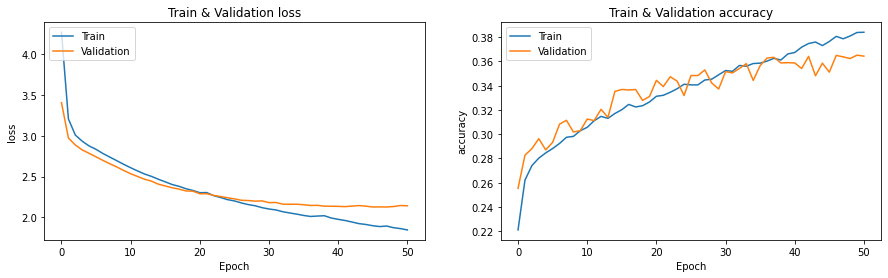

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Applied AI/CS2/Data/LSTM_VGG19_T2_1011.csv")

# Plot training & validation loss values
plt.figure(figsize=(15, 4)); plt.subplot(121)
plt.plot(list(df['loss'])); plt.plot(list(df['val_loss']))
plt.title('Train & Validation loss'); plt.ylabel('loss'); plt.xlabel('Epoch'); plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation Accuracy values
plt.subplot(122)
plt.plot(list(df['accuracy'])); plt.plot(list(df['val_accuracy']))
plt.title('Train & Validation accuracy'); plt.ylabel('accuracy'); plt.xlabel('Epoch'); plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
Test_accuracy = accuracy_metric(X_test,Y_test,[test_que,test_image],model_lstm_vgg19)
print("\nTest accuracy of LSTM+VGG19 Model 50k Datapoints:",Test_accuracy)  # 41.42

100%|██████████| 4501/4501 [00:01<00:00, 4467.36it/s]



Test accuracy of LSTM+VGG19 Model 50k Datapoints: 44.24202029178688


In [ ]:
model_lstm_vgg19.save('/content/drive/MyDrive/Applied AI/CS2/model/model_2lstm_vgg19_50k_1011_50.h5')

In [ ]:
# model_lstm_vgg19 = tf.keras.models.load_model('/content/drive/MyDrive/Applied AI/CS2/model/model_2lstm_vgg19_50k_1011_50.h5')

In [ ]:
# pickle.dump(model_lstm_vgg19, open("/content/drive/MyDrive/Applied AI/CS2/model/final_model.pkl", "wb"))

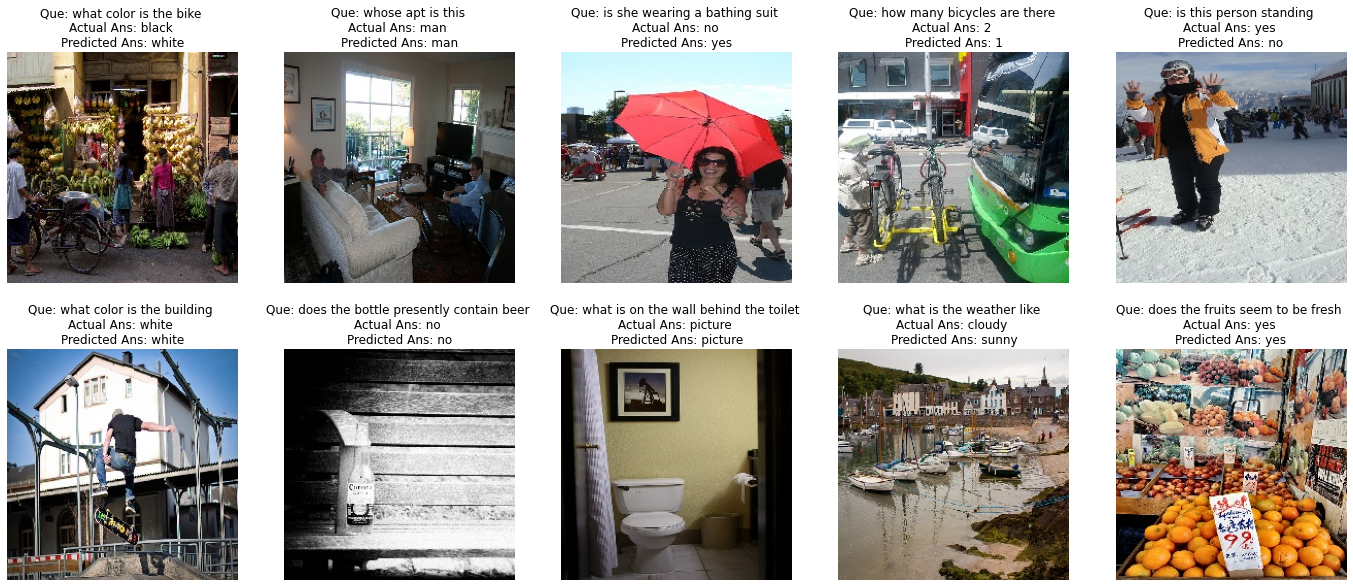

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question_preprocessed'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(10))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(colab_path+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {labelencoder.inverse_transform(test_answer)[i]} \nPredicted Ans: {labelencoder.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')

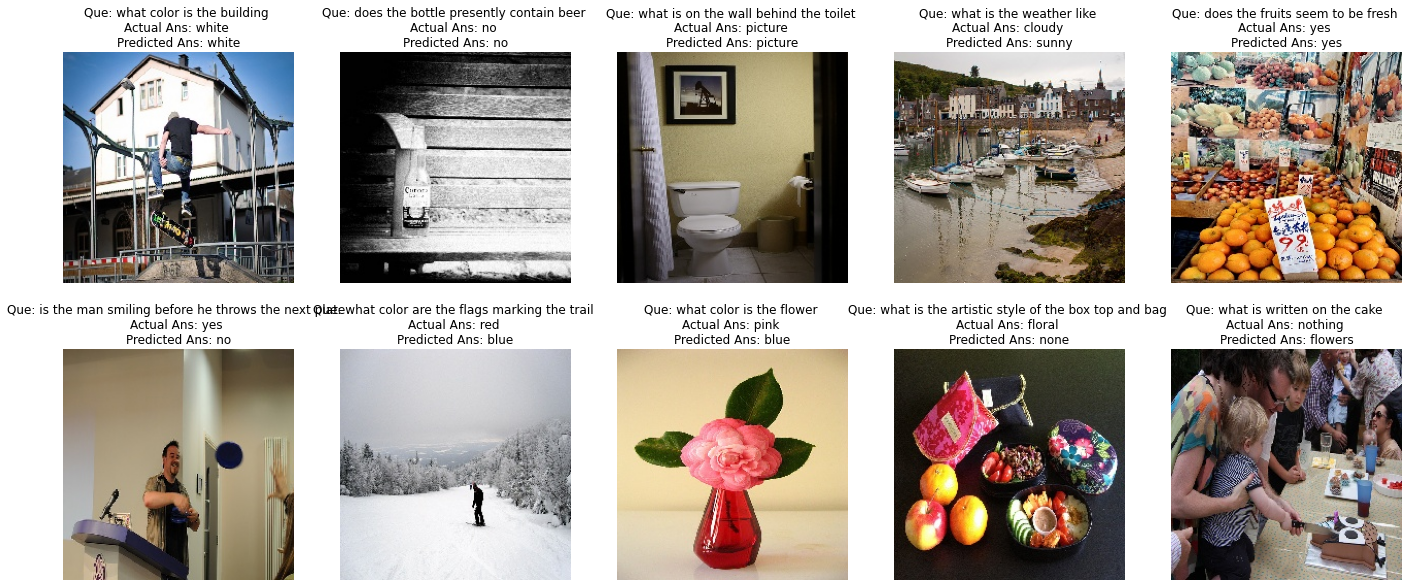

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question_preprocessed'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(5,15))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(colab_path+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {labelencoder.inverse_transform(test_answer)[i]} \nPredicted Ans: {labelencoder.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')

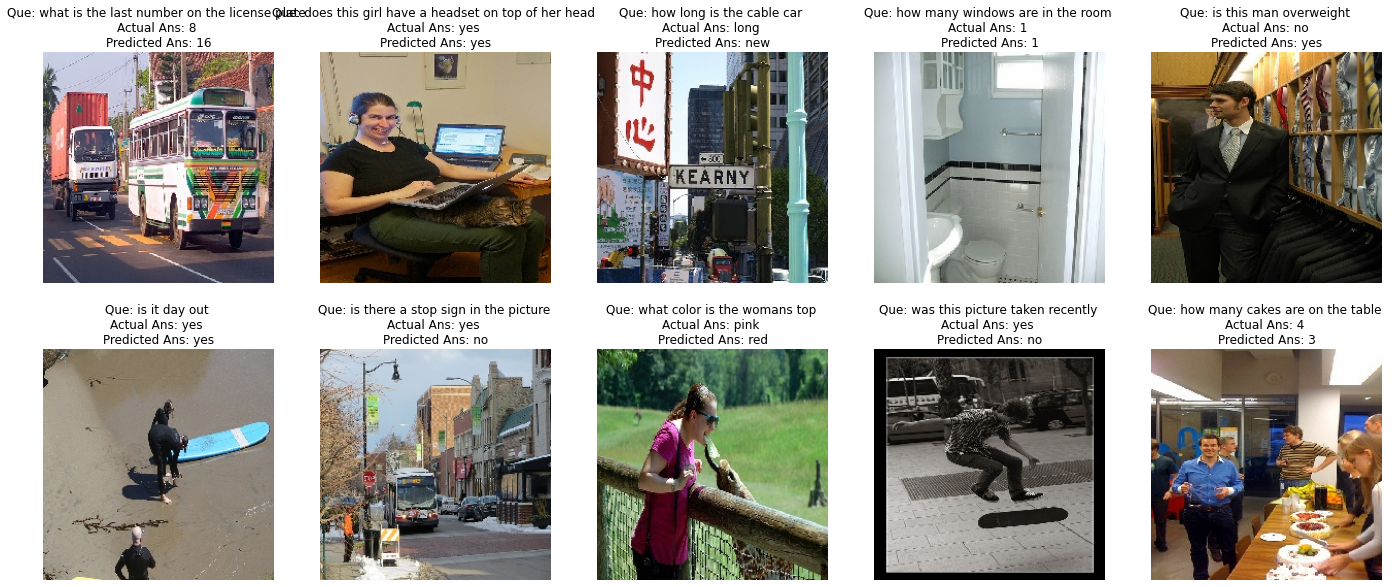

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question_preprocessed'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(20,30))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(colab_path+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {labelencoder.inverse_transform(test_answer)[i]} \nPredicted Ans: {labelencoder.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')

## 2. Results

In [ ]:
from prettytable import PrettyTable
x2 = PrettyTable(["Model", "Datapoints", "Class Labels", "Sampled Datapoints", "Epochs", "Train Accuracy", "Validation Accuracy", "Test Accuracy"])
x2.add_row(["LSTM+VGG19", "380554", "1000", "50000", "50", round(Train_accuracy,3), round(Val_accuracy,3), round(Test_accuracy,3)])
print(x2)

+------------+------------+--------------+--------------------+--------+----------------+---------------------+---------------+
|   Model    | Datapoints | Class Labels | Sampled Datapoints | Epochs | Train Accuracy | Validation Accuracy | Test Accuracy |
+------------+------------+--------------+--------------------+--------+----------------+---------------------+---------------+
| LSTM+VGG19 |   380554   |     1000     |       50000        |   50   |     49.699     |        44.251       |     44.242    |
+------------+------------+--------------+--------------------+--------+----------------+---------------------+---------------+
